<a href="https://colab.research.google.com/github/davidxu90/DS-Unit-2-Applied-Modeling/blob/master/Unit_2_Build_Week_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('all-states-history.csv')

In [ ]:
df.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,20200827,WY,B,37.0,NaN,0,NaN,215.0,215.0,13.0,...,74532.0,3954,NaN,NaN,NaN,NaN,73976.0,3993,104738.0,502
1,20200827,NE,A,386.0,NaN,3,NaN,1954.0,1954.0,166.0,...,348575.0,3815,NaN,NaN,NaN,NaN,349055.0,3812,NaN,0
2,20200827,ND,A,118.0,114.0,1,4.0,534.0,534.0,61.0,...,196559.0,1441,8329.0,NaN,NaN,NaN,196559.0,1441,449865.0,6969
3,20200827,NC,A+,2630.0,2630.0,24,NaN,NaN,NaN,958.0,...,2152725.0,31724,NaN,NaN,NaN,NaN,NaN,0,2152725.0,31724
4,20200827,MT,C,98.0,NaN,0,NaN,412.0,412.0,119.0,...,240659.0,2399,NaN,NaN,NaN,NaN,NaN,0,240659.0,2399


In [ ]:
import numpy as np
import datetime
from sklearn.preprocessing import OrdinalEncoder

def wrangle(df):
    temp = df.copy()
    
    temp['state'] = OrdinalEncoder().fit_transform(np.array(temp['state']).reshape(-1,1))
    
    quality_dict = {'F': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4, 'A+': 5}
    temp['dataQualityGrade'] = list(map(quality_dict.get, temp['dataQualityGrade']))
    
    temp2 = []
    for _, row in temp[['death', 'deathConfirmed', 'deathProbable']].iterrows():
        nan_list = list(map(np.isnan, row))
        if sum(nan_list) == 1:
            if nan_list[0]:
                row['death'] = row['deathConfirmed'] + row['deathProbable']
            elif nan_list[1]:
                row['deathConfirmed'] = row['death'] - row['deathProbable']
            else:
                row['deathProbable'] = row['death'] - row['deathConfirmed']
        temp2.append(row)
    temp[['death', 'deathConfirmed', 'deathProbable']] = temp2
    
    temp.interpolate(method = 'linear', limit_direction = 'backward', limit = 30, inplace = True)
    temp.fillna(0, inplace = True)
    
    temp['date'] = pd.to_datetime(temp['date'], format = '%Y%m%d')
    temp['date'] = temp['date'].map(datetime.datetime.toordinal)
    
    num_days = 10
    target = []
    for index, row in temp.iterrows():
        date = row['date']
        state = row['state']
        min_date = min(temp[temp['state'] == state]['date'])
        
        new_row = []
        for i in range(min(num_days, int(date - 4 - min_date))):
            previous_day_deaths = temp[(temp['date'] == date - i - 5) & (temp['state'] == state)]['positive'].values[0]
            new_row.append(previous_day_deaths)
        if len(new_row) < num_days:
            for i in range(num_days - len(new_row)):
                new_row.append(0)
        target.append(new_row)
    column_names = [str(i + 5) + ' Days Ago' for i in range(num_days)]
    target = pd.DataFrame(target, columns = column_names)
    
    temp.drop('date', axis = 1, inplace = True)
    
    return temp, target

X, y = wrangle(df)

In [ ]:
X.head()

,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,55.0,3.0,37.0,114.0,0,4.0,215.0,215.0,13.0,2,...,74532.0,3954,8329.000000,13323.0,29478.0,82573.0,73976.0,3993,104738.0,502
1,32.0,4.0,386.0,114.0,3,4.0,1954.0,1954.0,166.0,8,...,348575.0,3815,8329.000000,13323.0,29478.0,82573.0,349055.0,3812,277301.5,0
2,31.0,4.0,118.0,114.0,1,4.0,534.0,534.0,61.0,9,...,196559.0,1441,8329.000000,13323.0,29478.0,82573.0,196559.0,1441,449865.0,6969
3,30.0,5.0,2630.0,2630.0,24,0.0,473.0,473.0,958.0,0,...,2152725.0,31724,15579.666667,13323.0,29478.0,82573.0,199045.0,0,2152725.0,31724
4,29.0,2.0,98.0,1754.0,0,0.0,412.0,412.0,119.0,10,...,240659.0,2399,22830.333333,13323.0,29478.0,82573.0,201531.0,0,240659.0,2399


In [ ]:
y.head()

,5 Days Ago,6 Days Ago,7 Days Ago,8 Days Ago,9 Days Ago,10 Days Ago,11 Days Ago,12 Days Ago,13 Days Ago,14 Days Ago
0,3543.0,3524.0,3468.0,3430.0,3363.0,3331.0,3286.0,3227.0,3183.0,3119.0
1,31626.0,31348.0,31040.0,30825.0,30563.0,30372.0,30241.0,29988.0,29660.0,29244.0
2,9736.0,9474.0,9242.0,8968.0,8782.0,8647.0,8587.0,8444.0,8322.0,8171.0
3,153641.0,151912.0,149904.0,147932.0,146779.0,145516.0,144952.0,143706.0,142170.0,140824.0
4,6376.0,6216.0,6072.0,5956.0,5846.0,5792.0,5750.0,5659.0,5541.0,5407.0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 300,
                              max_features = 'sqrt',
                              max_depth = 14)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features='sqrt', n_estimators=300)

In [ ]:
from sklearn.metrics import explained_variance_score as evs

y_pred = model.predict(X_train)
print("% of training variance explained: " + str(evs(y_train, y_pred)))

y_pred = model.predict(X_val)
print("% of validation variance explained: " + str(evs(y_val, y_pred)))

% of training variance explained: 0.9997532437428921
% of validation variance explained: 0.998486997052687


In [ ]:
y_pred = model.predict(X_test)
print("% of test variance explained: " + str(evs(y_test, y_pred)))

% of test variance explained: 0.9977972311960723


In [ ]:
y_pred = []
for _, row in y_test.iterrows():
    average = row.mean()
    new_row = [average for _ in range(len(row))]
    y_pred.append(new_row)
y_pred = pd.DataFrame(y_pred)

print("Baseline explained variance: " + str(evs(y_test, y_pred)))

Baseline explained variance: 0.9971236554680638


In [ ]:
print(model.predict(X_test))

[[ 6183.49344072  5803.52177695  5440.22633351 ...  3860.83567813
   3579.39930233  3317.23586536]
 [  167.29221498   146.09291083   126.78699744 ...    59.26329195
     51.19735482    44.46606151]
 [13837.45556096 13513.79948253 13177.16604199 ... 11718.81629229
  11440.50156544 11167.50831232]
 ...
 [ 2902.50688854  2703.2085466   2523.47619717 ...  1694.94712765
   1560.24137845  1424.41434807]
 [ 4695.04232881  4467.89090827  4246.58671579 ...  3158.36114997
   2958.43755371  2767.98871953]
 [  239.7724008    230.84231468   223.40665107 ...   188.12777321
    181.64030462   175.8994508 ]]


In [ ]:
print(pd.DataFrame(model.predict(X_test)).columns)

RangeIndex(start=0, stop=10, step=1)


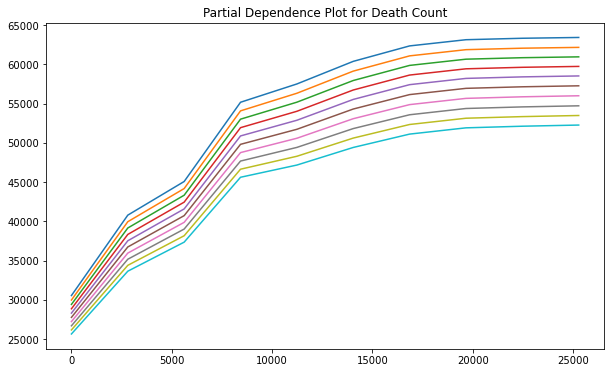

In [ ]:
import matplotlib.pyplot as plt

def custom_pdp(df, model, target_var, gradations, title):
    if target_var not in df.columns:
        return None
    
    minimum = min(df[target_var])
    maximum = max(df[target_var])
    
    values = [minimum + i * (maximum - minimum) / (gradations - 1) for i in range(gradations)]
    
    predictions = []
    for value in values:
        df2 = df.copy()
        df2[target_var] = value
        y_pred = pd.DataFrame(model.predict(df2))
        averages = [y_pred[column].mean() for column in y_pred.columns]
        predictions.append(averages)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(values, predictions)

custom_pdp(X_test, model, 'death', 10, 'Partial Dependence Plot for Death Count')

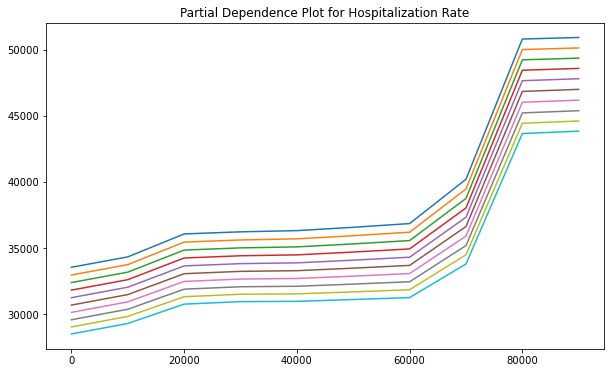

In [ ]:
custom_pdp(X_test, model, 'hospitalized', 10, 'Partial Dependence Plot for Hospitalization Rate')

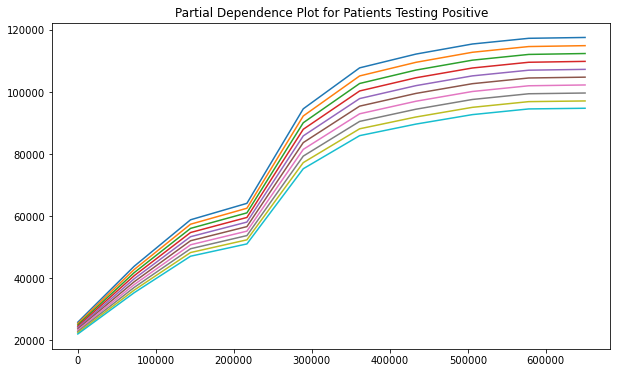

In [ ]:
custom_pdp(X_test, model, 'positive', 10, 'Partial Dependence Plot for Patients Testing Positive')

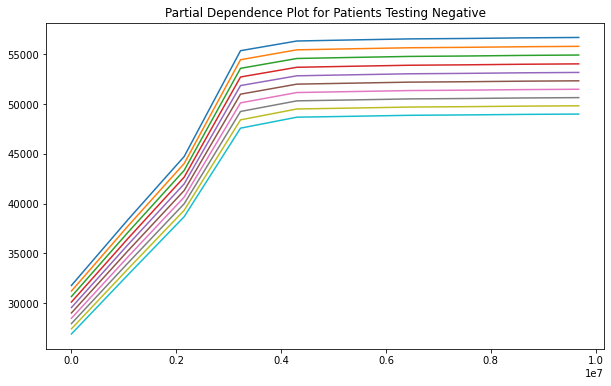

In [ ]:
custom_pdp(X_test, model, 'negative', 10, 'Partial Dependence Plot for Patients Testing Negative')

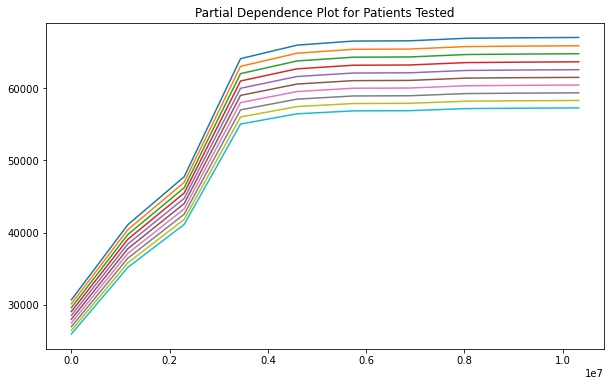

In [ ]:
custom_pdp(X_test, model, 'totalTestResults', 10, 'Partial Dependence Plot for Patients Tested')